In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .83)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, SMOTE




0    649
1     64
Name: binding, dtype: int64
0    73
1    14
Name: binding, dtype: int64


In [9]:
sampler = RandomOverSampler(sampling_strategy=.85)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    649
1    551
Name: binding, dtype: int64
0    73
1    14
Name: binding, dtype: int64


In [10]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [11]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())

In [12]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [13]:
# smote = SMOTE(random_state=42)
# x, y = smote.fit_resample(training_split, train_result)
# training_split = x
# train_result = y
# print(training_split.shape)
# print(test_split.shape)

In [14]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [15]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [16]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [17]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [18]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( .35 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [19]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .55:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [20]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [21]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = .0085 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [22]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
Metal device set to: Apple M1
bfore traning:  45.95238095238095
Epoch 1/60


2022-11-14 01:40:42.124840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 01:40:42.125000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-14 01:40:42.304241: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 01:40:42.556502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/6 [========================>.....] - ETA: 0s - loss: 4.6365 - tp: 144.0000 - fp: 142.0000 - tn: 48.0000 - fn: 16.0000 - precision: 0.5035 - recall: 0.9000

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6590476374014154
Recall TRAINING:  0.8963730335235596
6/6 [==============================] - 1s 14ms/step - loss: 4.3595 - tp: 173.0000 - fp: 159.0000 - tn: 68.0000 - fn: 20.0000 - precision: 0.5211 - recall: 0.8964



****** Early Stopping *******
38/38 [==============================] - 0s 3ms/step


2022-11-14 01:40:43.058710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6942372881355933
0.6241666666666666
error_rate: 0.000313194444444446
0.9999999999999905
 =========== iteration ===========>: 1
bfore traning:  44.047619047619044
Epoch 1/60


2022-11-14 01:40:43.556377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 15ms/step - loss: 4.4079 - tp: 79.0000 - fp: 93.0000 - tn: 142.0000 - fn: 106.0000 - precision: 0.4593 - recall: 0.4270
Epoch 2/60
6/6 [==============================] - 0s 12ms/step - loss: 1.7976 - tp: 81.0000 - fp: 18.0000 - tn: 217.0000 - fn: 104.0000 - precision: 0.8182 - recall: 0.4378
Epoch 3/60
6/6 [==============================] - 0s 13ms/step - loss: 0.9542 - tp: 76.0000 - fp: 0.0000e+00 - tn: 235.0000 - fn: 109.0000 - precision: 1.0000 - recall: 0.4108
Epoch 4/60
5/6 [========================>.....] - ETA: 0s - loss: 0.8855 - tp: 105.0000 - fp: 0.0000e+00 - tn: 196.0000 - fn: 49.0000 - precision: 1.0000 - recall: 0.6818

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8141025613839105
Recall TRAINING:  0.6864864826202393
6/6 [==============================] - 0s 13ms/step - loss: 0.8562 - tp: 127.0000 - fp: 0.0000e+00 - tn: 235.0000 - fn: 58.0000 - precision: 1.0000 - recall: 0.6865



****** Early Stopping *******
38/38

2022-11-14 01:40:44.271832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8436516264428122
0.8758333333333334
error_rate: 9.873166538754866e-05
0.9999999999999977
 =========== iteration ===========>: 2
bfore traning:  46.42857142857143
Epoch 1/60


2022-11-14 01:40:44.714270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 15ms/step - loss: 4.3684 - tp: 32.0000 - fp: 33.0000 - tn: 192.0000 - fn: 163.0000 - precision: 0.4923 - recall: 0.1641
Epoch 2/60
6/6 [==============================] - 0s 11ms/step - loss: 1.7661 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 225.0000 - fn: 195.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
6/6 [==============================] - 0s 11ms/step - loss: 0.9536 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 225.0000 - fn: 195.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
6/6 [==============================] - 0s 10ms/step - loss: 0.8515 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 225.0000 - fn: 195.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
6/6 [==============================] - 0s 13ms/step - loss: 0.5501 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 225.0000 - fn: 195.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
6/6 [==============================] - 0s 12ms/step - loss: 0.4650 - tp: 0.0000

2022-11-14 01:40:49.032538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/6 [====>.........................] - ETA: 1s - loss: 5.9467 - tp: 12.0000 - fp: 16.0000 - tn: 26.0000 - fn: 16.0000 - precision: 0.4286 - recall: 0.4286

2022-11-14 01:40:49.433528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 14ms/step - loss: 4.4244 - tp: 97.0000 - fp: 67.0000 - tn: 166.0000 - fn: 90.0000 - precision: 0.5915 - recall: 0.5187
Epoch 2/60
6/6 [==============================] - ETA: 0s - loss: 1.8404 - tp: 163.0000 - fp: 22.0000 - tn: 211.0000 - fn: 24.0000 - precision: 0.8811 - recall: 0.8717

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8763441150545632
Recall TRAINING:  0.8716577887535095
6/6 [==============================] - 0s 12ms/step - loss: 1.8404 - tp: 163.0000 - fp: 22.0000 - tn: 211.0000 - fn: 24.0000 - precision: 0.8811 - recall: 0.8717



****** Early Stopping *******
38/38 [==============================] - 0s 3ms/step
0.9774977497749775
0.9791666666666666
error_rate: 1.74288114039439e-05
1.0000000000000095
 =========== iteration ===========>: 4
bfore traning:  46.19047619047619
Epoch 1/60


2022-11-14 01:40:49.801927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/6 [====>.........................] - ETA: 1s - loss: 5.9440 - tp: 13.0000 - fp: 16.0000 - tn: 20.0000 - fn: 21.0000 - precision: 0.4483 - recall: 0.3824

2022-11-14 01:40:50.201304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/6 [===================>..........] - ETA: 0s - loss: 4.9550 - tp: 67.0000 - fp: 65.0000 - tn: 78.0000 - fn: 70.0000 - precision: 0.5076 - recall: 0.4891

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.5496183443083659
Recall TRAINING:  0.5567010641098022
6/6 [==============================] - 0s 17ms/step - loss: 4.3860 - tp: 108.0000 - fp: 91.0000 - tn: 135.0000 - fn: 86.0000 - precision: 0.5427 - recall: 0.5567



****** Early Stopping *******
38/38 [==============================] - 0s 4ms/step


2022-11-14 01:40:50.535647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7688564476885645
0.7625
error_rate: 0.0001980104492929068
0.9999999999999936
 =========== iteration ===========>: 5
bfore traning:  48.095238095238095
Epoch 1/60
1/6 [====>.........................] - ETA: 1s - loss: 5.9422 - tp: 10.0000 - fp: 27.0000 - tn: 15.0000 - fn: 18.0000 - precision: 0.2703 - recall: 0.3571

2022-11-14 01:40:50.979040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 15ms/step - loss: 4.3740 - tp: 67.0000 - fp: 119.0000 - tn: 99.0000 - fn: 135.0000 - precision: 0.3602 - recall: 0.3317
Epoch 2/60
6/6 [==============================] - 0s 14ms/step - loss: 1.7721 - tp: 105.0000 - fp: 65.0000 - tn: 153.0000 - fn: 97.0000 - precision: 0.6176 - recall: 0.5198
Epoch 3/60
6/6 [==============================] - ETA: 0s - loss: 0.9488 - tp: 198.0000 - fp: 32.0000 - tn: 186.0000 - fn: 4.0000 - precision: 0.8609 - recall: 0.9802 

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9166667150852185
Recall TRAINING:  0.9801980257034302
6/6 [==============================] - 0s 12ms/step - loss: 0.9488 - tp: 198.0000 - fp: 32.0000 - tn: 186.0000 - fn: 4.0000 - precision: 0.8609 - recall: 0.9802



****** Early Stopping *******
38/38 [==============================] - 0s 3ms/step


2022-11-14 01:40:51.444540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8787878787878788
0.8733333333333333
error_rate: 0.00010641458294004979
0.999999999999994
 =========== iteration ===========>: 6
bfore traning:  51.42857142857142
Epoch 1/60
1/6 [====>.........................] - ETA: 1s - loss: 5.9606 - tp: 31.0000 - fp: 31.0000 - tn: 4.0000 - fn: 4.0000 - precision: 0.5000 - recall: 0.8857

2022-11-14 01:40:51.895385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/6 [========================>.....] - ETA: 0s - loss: 4.6873 - tp: 169.0000 - fp: 142.0000 - tn: 30.0000 - fn: 9.0000 - precision: 0.5434 - recall: 0.9494

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7032589891795125
Recall TRAINING:  0.9490740895271301
6/6 [==============================] - 0s 15ms/step - loss: 4.4127 - tp: 205.0000 - fp: 162.0000 - tn: 42.0000 - fn: 11.0000 - precision: 0.5586 - recall: 0.9491



****** Early Stopping *******
38/38 [==============================] - 0s 3ms/step


2022-11-14 01:40:52.239903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7363387978142075
0.6783333333333333
error_rate: 0.0002698384470560438
1.000000000000021
 =========== iteration ===========>: 7
bfore traning:  42.61904761904762
Epoch 1/60
1/6 [====>.........................] - ETA: 1s - loss: 5.9540 - tp: 15.0000 - fp: 6.0000 - tn: 33.0000 - fn: 16.0000 - precision: 0.7143 - recall: 0.4839

2022-11-14 01:40:52.668155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 19ms/step - loss: 4.3855 - tp: 73.0000 - fp: 39.0000 - tn: 202.0000 - fn: 106.0000 - precision: 0.6518 - recall: 0.4078
Epoch 2/60
6/6 [==============================] - 0s 11ms/step - loss: 1.7749 - tp: 40.0000 - fp: 12.0000 - tn: 229.0000 - fn: 139.0000 - precision: 0.7692 - recall: 0.2235
Epoch 3/60
6/6 [==============================] - 0s 11ms/step - loss: 0.9523 - tp: 19.0000 - fp: 0.0000e+00 - tn: 241.0000 - fn: 160.0000 - precision: 1.0000 - recall: 0.1061
Epoch 4/60
6/6 [==============================] - 0s 11ms/step - loss: 0.8511 - tp: 19.0000 - fp: 0.0000e+00 - tn: 241.0000 - fn: 160.0000 - precision: 1.0000 - recall: 0.1061
Epoch 5/60
6/6 [==============================] - 0s 12ms/step - loss: 0.5524 - tp: 11.0000 - fp: 0.0000e+00 - tn: 241.0000 - fn: 168.0000 - precision: 1.0000 - recall: 0.0615
Epoch 6/60
6/6 [==============================] - 0s 11ms/step - loss: 0.4642 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 179.

2022-11-14 01:40:56.291517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


bfore traning:  47.85714285714286
Epoch 1/60
1/6 [====>.........................] - ETA: 1s - loss: 5.9418 - tp: 8.0000 - fp: 6.0000 - tn: 28.0000 - fn: 28.0000 - precision: 0.5714 - recall: 0.2222

2022-11-14 01:40:56.701319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 16ms/step - loss: 4.3751 - tp: 86.0000 - fp: 71.0000 - tn: 148.0000 - fn: 115.0000 - precision: 0.5478 - recall: 0.4279
Epoch 2/60
6/6 [==============================] - 0s 14ms/step - loss: 1.7714 - tp: 63.0000 - fp: 24.0000 - tn: 195.0000 - fn: 138.0000 - precision: 0.7241 - recall: 0.3134
Epoch 3/60
6/6 [==============================] - 0s 12ms/step - loss: 0.9529 - tp: 71.0000 - fp: 0.0000e+00 - tn: 219.0000 - fn: 130.0000 - precision: 1.0000 - recall: 0.3532
Epoch 4/60
6/6 [==============================] - 0s 11ms/step - loss: 0.8513 - tp: 55.0000 - fp: 0.0000e+00 - tn: 219.0000 - fn: 146.0000 - precision: 1.0000 - recall: 0.2736
Epoch 5/60
6/6 [==============================] - 0s 10ms/step - loss: 0.5541 - tp: 32.0000 - fp: 0.0000e+00 - tn: 219.0000 - fn: 169.0000 - precision: 1.0000 - recall: 0.1592
Epoch 6/60
6/6 [==============================] - 0s 11ms/step - loss: 0.4649 - tp: 3.0000 - fp: 0.0000e+00 - tn: 219.0000 - fn: 198.0000

2022-11-14 01:41:00.476170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


bfore traning:  49.76190476190476
Epoch 1/60


2022-11-14 01:41:01.031019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/6 [==============>...............] - ETA: 0s - loss: 5.2721 - tp: 85.0000 - fp: 93.0000 - tn: 19.0000 - fn: 13.0000 - precision: 0.4775 - recall: 0.8673

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6510791612886297
Recall TRAINING:  0.8660287857055664
6/6 [==============================] - 1s 20ms/step - loss: 4.3852 - tp: 181.0000 - fp: 166.0000 - tn: 45.0000 - fn: 28.0000 - precision: 0.5216 - recall: 0.8660



****** Early Stopping *******
38/38 [==============================] - 0s 3ms/step
0.6626666666666667
0.5783333333333334
error_rate: 0.00034666423118379157
1.0000000000000033
 =========== iteration ===========>: 10
bfore traning:  45.23809523809524
Epoch 1/60


2022-11-14 01:41:01.434863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/6 [====>.........................] - ETA: 2s - loss: 5.9500 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 26.0000 - precision: 0.0000e+00 - recall: 0.0000e+00

2022-11-14 01:41:01.850583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 15ms/step - loss: 4.4012 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 230.0000 - fn: 190.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
6/6 [==============================] - 0s 17ms/step - loss: 1.8031 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 230.0000 - fn: 190.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
6/6 [==============================] - 0s 12ms/step - loss: 0.9532 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 230.0000 - fn: 190.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
6/6 [==============================] - 0s 11ms/step - loss: 0.8512 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 230.0000 - fn: 190.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
6/6 [==============================] - 0s 10ms/step - loss: 0.5624 - tp: 32.0000 - fp: 0.0000e+00 - tn: 230.0000 - fn: 158.0000 - precision: 1.0000 - recall: 0.1684    
Epoch 6/60
6/6 [==============================] - 0s 9ms/step - loss: 0.4627 - tp: 

2022-11-14 01:41:03.622143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


bfore traning:  48.80952380952381
Epoch 1/60


2022-11-14 01:41:04.034099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/6 [===================>..........] - ETA: 0s - loss: 4.9667 - tp: 117.0000 - fp: 110.0000 - tn: 37.0000 - fn: 16.0000 - precision: 0.5154 - recall: 0.8797

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6641791215941133
Recall TRAINING:  0.8682926893234253
6/6 [==============================] - 1s 18ms/step - loss: 4.3951 - tp: 178.0000 - fp: 153.0000 - tn: 62.0000 - fn: 27.0000 - precision: 0.5378 - recall: 0.8683



****** Early Stopping *******
38/38 [==============================] - 0s 3ms/step
0.688128772635815
0.6125
error_rate: 0.00032325010908524645
1.000000000000011


2022-11-14 01:41:04.422561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [23]:
alphas

[0.06858117125267017,
 0.0783955518656667,
 0.06935919662327784,
 0.09313763194688227,
 0.07247943815739744,
 0.07775852285621321,
 0.06984804660308806,
 0.07220514272046141,
 0.07244967737728393,
 0.06771786082276912,
 0.07134431388582597,
 0.06831246765410273]

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [25]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [26]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = ( precision , recall, (2*precision*recall)/(precision+recall))
    return score

In [27]:
f1_test = []
acc_test = []
for i in range(1,ensemble_size+1):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    acc_test.append(accuracy_score(test_result, ans))

*********: 0
3/3 [==============================] - 0s 12ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 9ms/step


2022-11-14 01:41:12.161418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-14 01:41:12.296159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_1586/354829567.py:3: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)


*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 8ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 5ms/step


2022-11-14 01:41:12.478410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 11ms/step
*********: 0
3/3 [==============================] - 0s 5ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 4ms/step


2022-11-14 01:41:12.686132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 9ms/step
*********: 0
3/3 [==============================] - 0s 5ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 4ms/step


2022-11-14 01:41:12.972038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 5ms/step
*********: 4
3/3 [==============================] - 0s 6ms/step
*********: 5
3/3 [==============================] - 0s 7ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step


2022-11-14 01:41:13.280644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 5ms/step
*********: 6
3/3 [==============================] - 0s 8ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
1/3 [=========>....................] - ETA: 0s

2022-11-14 01:41:13.636319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 5ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 9ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
1/3 [=========>....................] - ETA: 0s

2022-11-14 01:41:14.011079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 5ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 9ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 4ms/step


2022-11-14 01:41:14.433739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 6ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 5ms/step
*********: 8
3/3 [==============================] - 0s 4ms/step
*********: 9
3/3 [==============================] - 0s 8ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step


2022-11-14 01:41:14.942493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 4
3/3 [==============================] - 0s 5ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 4ms/step
*********: 8
3/3 [==============================] - 0s 3ms/step
*********: 9
3/3 [==============================] - 0s 4ms/step
*********: 10
3/3 [==============================] - 0s 8ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step


2022-11-14 01:41:15.439468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 4ms/step
*********: 8
3/3 [==============================] - 0s 4ms/step
*********: 9
3/3 [==============================] - 0s 4ms/step
*********: 10
3/3 [==============================] - 0s 3ms/step
*********: 11
3/3 [==============================] - 0s 9ms/step


2022-11-14 01:41:15.985808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
f1_train = []
acc_train = []
for i in range(1,ensemble_size+1):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    acc_train.append(accuracy_score(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
38/38 [==============================] - 0s 3ms/step
*********: 0
38/38 [==============================] - 0s 3ms/step
*********: 1
38/38 [==============================] - 0s 3ms/step
*********: 0
38/38 [==============================] - 0s 3ms/step
*********: 1
38/38 [==============================] - 0s 3ms/step
*********: 2
38/38 [==============================] - 0s 3ms/step
*********: 0
38/38 [==============================] - 0s 3ms/step
*********: 1
38/38 [==============================] - 0s 3ms/step
*********: 2
38/38 [==============================] - 0s 3ms/step
*********: 3
38/38 [==============================] - 0s 3ms/step
*********: 0
38/38 [==============================] - 0s 3ms/step
*********: 1
38/38 [==============================] - 0s 2ms/step
*********: 2
38/38 [==============================] - 0s 3ms/step
*********: 3
38/38 [==============================] - 0s 3ms/step
*********: 4
38/38 [==============================] - 0s 3ms/step
*********:

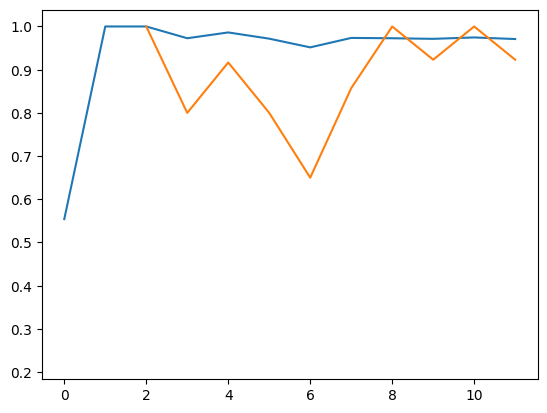

In [29]:

plt.plot([i[0] for i in f1_train])
plt.plot([i[0] for i in f1_test])
# plt.plot()

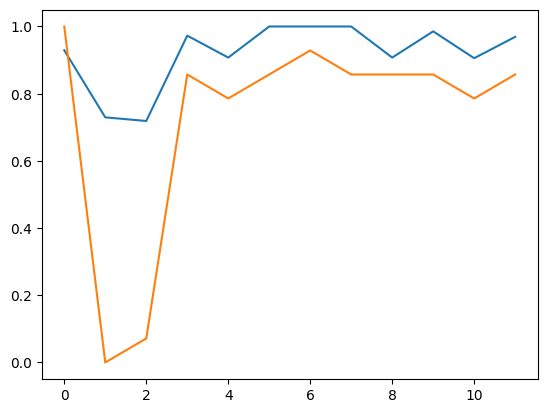

In [30]:
plt.plot([i[1] for i in f1_train])
plt.plot([i[1] for i in f1_test])

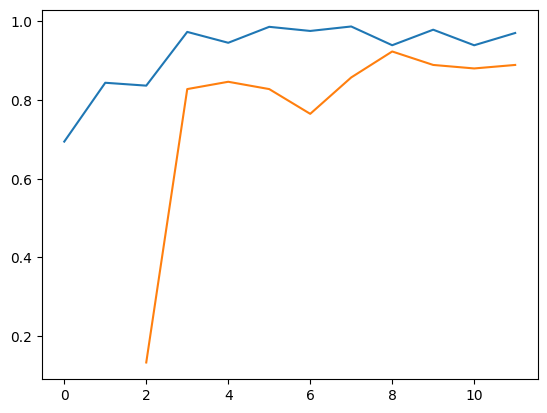

In [31]:
plt.plot([i[2] for i in f1_train])
plt.plot([i[2] for i in f1_test])

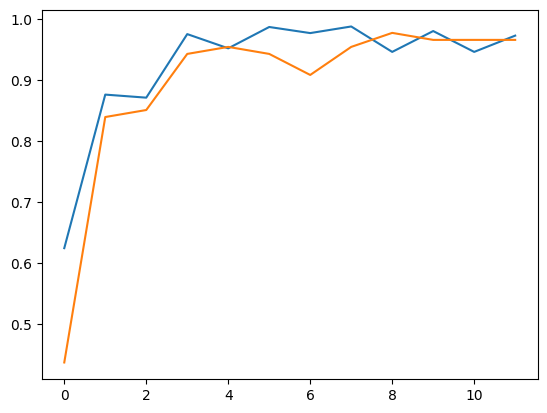

In [32]:
plt.plot(acc_train)
plt.plot(acc_test)

In [1136]:
value = 5
data = some_pred(training_split, value+1)
ans = majority(data)
data = some_pred(test_split, value +1)
ans1 = majority(data)


*********: 0
38/38 [==============================] - 0s 4ms/step
*********: 1
38/38 [==============================] - 0s 3ms/step
*********: 2
38/38 [==============================] - 0s 3ms/step
*********: 3
38/38 [==============================] - 0s 4ms/step
*********: 4
38/38 [==============================] - 0s 3ms/step
*********: 5
38/38 [==============================] - 0s 4ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 4ms/step


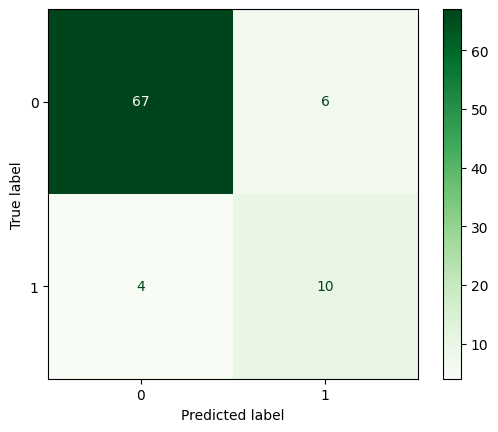

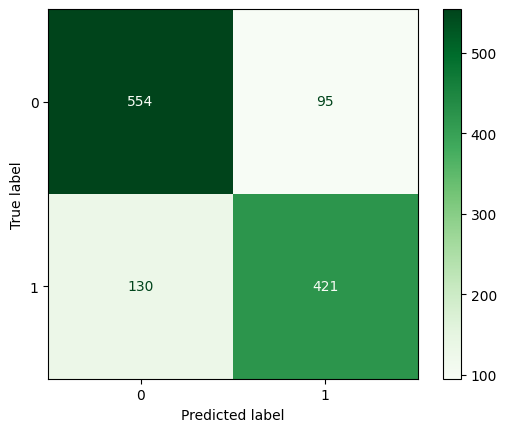

In [1137]:
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [33]:
value = 8
data = some_pred(training_split, value+1)
ans = majority(data)
data = some_pred(test_split, value+1 )
ans1 = majority(data)

*********: 0
38/38 [==============================] - 0s 3ms/step
*********: 1
38/38 [==============================] - 0s 3ms/step
*********: 2
38/38 [==============================] - 0s 3ms/step
*********: 3
38/38 [==============================] - 0s 3ms/step
*********: 4
38/38 [==============================] - 0s 3ms/step
*********: 5
38/38 [==============================] - 0s 3ms/step
*********: 6
38/38 [==============================] - 0s 3ms/step
*********: 7
38/38 [==============================] - 0s 2ms/step
*********: 8
38/38 [==============================] - 0s 3ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [====

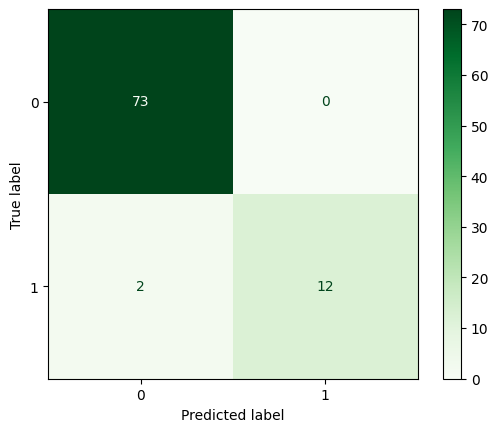

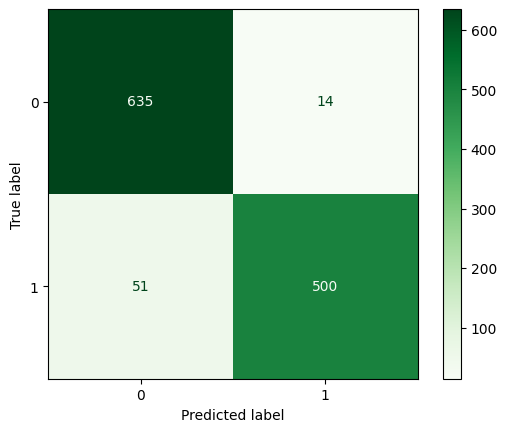

In [34]:
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [38]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 8+1))

*********: 0
11/11 [==============================] - 0s 4ms/step
*********: 1
11/11 [==============================] - 0s 3ms/step
*********: 2
11/11 [==============================] - 0s 3ms/step
*********: 3
11/11 [==============================] - 0s 3ms/step
*********: 4
11/11 [==============================] - 0s 2ms/step
*********: 5
11/11 [==============================] - 0s 3ms/step
*********: 6
11/11 [==============================] - 0s 3ms/step
*********: 7
11/11 [==============================] - 0s 3ms/step
*********: 8
11/11 [==============================] - 0s 3ms/step


In [39]:
len(predicted_data)

350

In [40]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()